In [ ]:
!pip3 install matplotlib scipy

Just picture

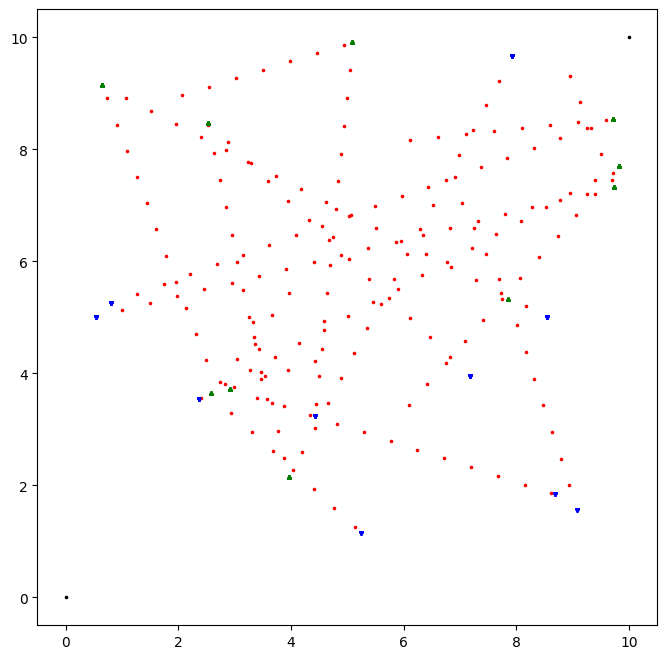

In [171]:

acroutes = [ActiveRoute(c, o) for c, o in zip(couriers, orders)]

fig, ax = plt.subplots()
frame = (Point(0, 0), Point(10, 10))
frame[0].plot(ax, color='black')
frame[1].plot(ax, color='black')
fig.set_figheight(8)
fig.set_figwidth(8)

for iter in range(100):
    for ar in acroutes:
        if ar.is_active:
            ar.plot(ax)
            ar.next(0.5)

Base launch

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import utils
import dispatch
import simulator
import dispatch.network
import importlib
importlib.reload(utils)
importlib.reload(dispatch.dispatch)
importlib.reload(dispatch.scorings)
importlib.reload(simulator.base_simulator)
importlib.reload(simulator.visualization)

from utils import *
from dispatch.dispatch import Dispatch
from simulator.base_simulator import BaseSimulator
from simulator.visualization import Visualizer

c:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


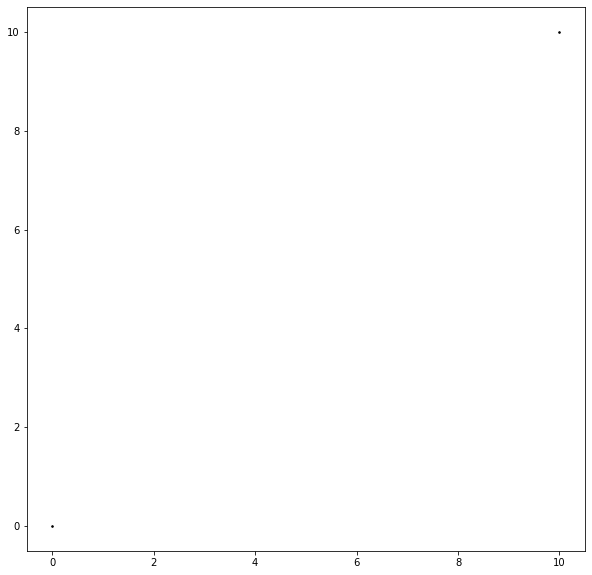

In [61]:
dsp = Dispatch()
sim = BaseSimulator(dsp, 0.5)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
    
sim.corner_bounds[0].plot(ax, color='black')
sim.corner_bounds[1].plot(ax, color='black')

all_metrics = []
for i in range(2000):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()
    # for ar in sim.active_routes:
    #     ar.plot(ax)

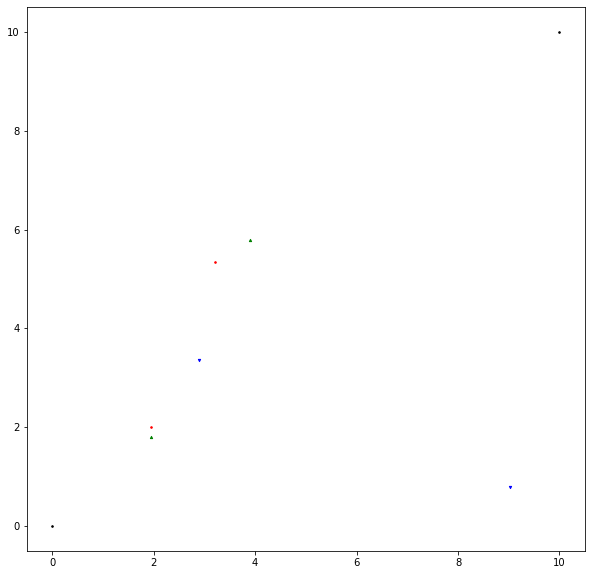

In [55]:
# hand launch visualization
sim.Next()
for ar in sim.active_routes:
    ar.plot(ax)
fig

mrtrics

CR:  0.9880216536408191


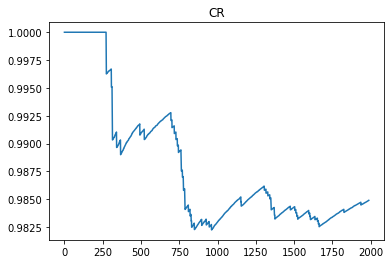

current free couriers:  31.109
current free orders:  0.905
current active routes:  28.891


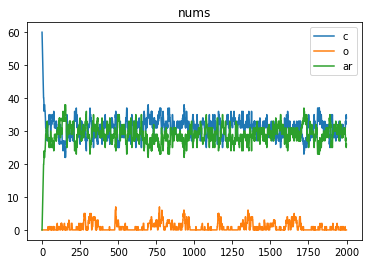

In [63]:
plt.title('CR')
plt.plot([m['completed_orders'] / m['finished_orders'] for m in all_metrics if m['finished_orders'] != 0])
print('CR: ', np.mean([m['completed_orders'] / m['finished_orders'] for m in all_metrics if m['finished_orders'] != 0]))
plt.show()
plt.title('nums')
plt.plot([m['current_free_couriers'] for m in all_metrics], label='c')
plt.plot([m['current_free_orders'] for m in all_metrics], label='o')
plt.plot([m['current_active_routes'] for m in all_metrics], label='ar')
plt.legend()
print('current free couriers: ', np.mean([m['current_free_couriers'] for m in all_metrics]))
print('current free orders: ', np.mean([m['current_free_orders'] for m in all_metrics]))
print('current active routes: ', np.mean([m['current_active_routes'] for m in all_metrics]))

In [64]:
sim.GetMetrics()

{'iter': 2000,
 'completed_orders': 3913,
 'finished_orders': 3973,
 'current_free_couriers': 34,
 'current_free_orders': 1,
 'current_active_routes': 26,
 'total_eta': 0.20270903438005933}

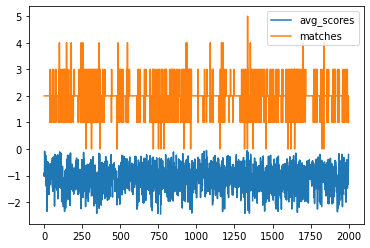

In [65]:
plt.plot(sim.dispatch.statistics['avg_scores'], label='avg_scores')
plt.plot(sim.dispatch.statistics['num_assignments'], label='matches')
plt.legend()

Net launch

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import time

import utils
import dispatch
import simulator
import networks
import importlib
importlib.reload(utils)
importlib.reload(dispatch.dispatch)
importlib.reload(dispatch.scorings)
importlib.reload(simulator.base_simulator)
importlib.reload(simulator.visualization)
importlib.reload(networks.scoring_v1)
importlib.reload(networks.scoring_demo)
importlib.reload(networks.encoders)

from utils import *
from networks.model_trainer import ModelTrainer
from dispatch.utils import *
from dispatch.solvers import HungarianSolver
from networks.scoring_v1 import ScoringNet
from networks.scoring_demo import ScoringNetDemo
from networks.points_distance_net import PointDistNet
from networks.encoders import PointEncoder
from dispatch.scorings import ETAScoring
from dispatch.dispatch import Dispatch
from simulator.base_simulator import BaseSimulator
from simulator.visualization import Visualizer
from IPython.display import clear_output
from matplotlib.pyplot import figure

In [239]:
def make_target_score_tensor(np_scores, mask):
    with torch.no_grad():
        target = mask.float()
        for idx, scores in enumerate(np_scores):
            source = torch.tensor(scores, device=mask.device)
            target[idx][:source.shape[-2], :source.shape[-1]] = source
            
        return target

def make_target_assignment_tensor(np_scores, mask):
    solver = HungarianSolver()
    with torch.no_grad():
        target = torch.zeros(mask.shape, device=mask.device)
        for idx, scores in enumerate(np_scores):
            row_ids, col_ids = solver(scores)
            for row, col in zip(row_ids, col_ids):
                target[idx][row][col] = 1.0
            
        return target

def make_target_assignment_indexes_tensor(np_scores, mask):
    solver = HungarianSolver()
    with torch.no_grad():
        tgt_ass = -torch.ones((mask.shape[0], mask.shape[1]), device=mask.device, dtype=torch.long)
        for idx, scores in enumerate(np_scores):
            row_ids, col_ids = solver(scores)
            for row, col in zip(row_ids, col_ids):
                tgt_ass[idx][row] = col

    return tgt_ass

def get_hard_assignments(preds):
    z = torch.zeros_like(preds)
    o = torch.ones_like(preds)
    preds_hard = torch.scatter(z, dim=-1, index=torch.argmax(preds, dim=-1, keepdim=True), src=o)

    return preds_hard

def get_loss(net, triples):
    scorer = ETAScoring()
    np_scores = [scorer(triple.orders, triple.couriers) for triple in triples]
    preds = net(triples, 0)
    mask = net.get_mask()
    tgt = make_target_score_tensor(np_scores, mask)

    mse_loss = nn.MSELoss(reduction='none')
    return (mse_loss(preds, tgt) * mask).sum() / mask.sum()

def masked_softmax(preds, mask):
    mask_inf = (1 - mask) * -1e9
    return F.softmax(preds + mask_inf, dim=-1)

def get_loss_solve(net, triples, metrics=defaultdict(list)):    
    scorer = ETAScoring()
    np_scores = [scorer(triple.orders, triple.couriers) for triple in triples]
    preds = net(triples, 0)
    mask = net.get_mask()
    # pred_ass = get_hard_assignments(preds)
    tgt_ass = make_target_assignment_indexes_tensor(np_scores, mask)
    
    update_accuracy_metric(metrics, preds, tgt_ass)
    # update_grad_norm(metrics, net)
    ce_loss = nn.CrossEntropyLoss(reduction='sum', ignore_index=-1)
    return ce_loss(masked_softmax(preds, mask).transpose(1, 2), tgt_ass) / mask.sum()

def update_accuracy_metric(metrics, preds, tgt_ass):
    preds_hard = torch.argmax(preds, dim=-1)
    assert preds_hard.shape == tgt_ass.shape
    accuracy = ((preds_hard == tgt_ass) & (tgt_ass != -1)).sum() / (tgt_ass != -1).sum()
    metrics['accuracy'].append(accuracy.item())
    # eta_net = torch.max(preds, dim=-1).sum() / pred_ass.sum()
    # eta_solver = torch.max

def update_grad_norm(metrics, net):
    grad_norms = []
    for name, param in net.named_parameters():
        if not param.requires_grad or param.grad is None:
            continue
        grad_norms.append(torch.square(param.grad).mean())
    metrics['grad_norm'].append(np.log(np.mean(grad_norms)))

def print_info(epoch, metrics, losses):
    clear_output()
    print('EPOCH: ', epoch)
    print(losses[-50:])
    # plt.plot(np.log(losses))
    figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(1, 3, 2)
    plt.title('accuracy')
    plt.plot(metrics['accuracy'])
    plt.subplot(1, 3, 3)
    plt.title('grad_norm')
    plt.plot(metrics['grad_norm'])
    plt.show()

In [240]:
batch_size = 64
n_epochs = 1 + 1
n_iters = 1
bounds = (Point(0, 0), Point(10, 10))
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

point_encoder = PointEncoder(64, device=device)
point_encoder.load_state_dict(torch.load('encoder64.pt', map_location=device))

net = ScoringNetDemo(
    mode='default',
    point_encoder=point_encoder,
    n_layers=4,
    d_model=128,
    n_head=4,
    dim_ff=128,
    point_enc_dim=32,
    number_enc_dim=8,
    device=device
)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs=n_epochs, steps_per_epoch=n_iters)

losses = []
metrics = {
    'target_eta': [],
    'net_eta': [],
    'accuracy': [],
    'grad_norm': [],
}

EPOCH:  1
[0.427936315536499, 0.42171135544776917]


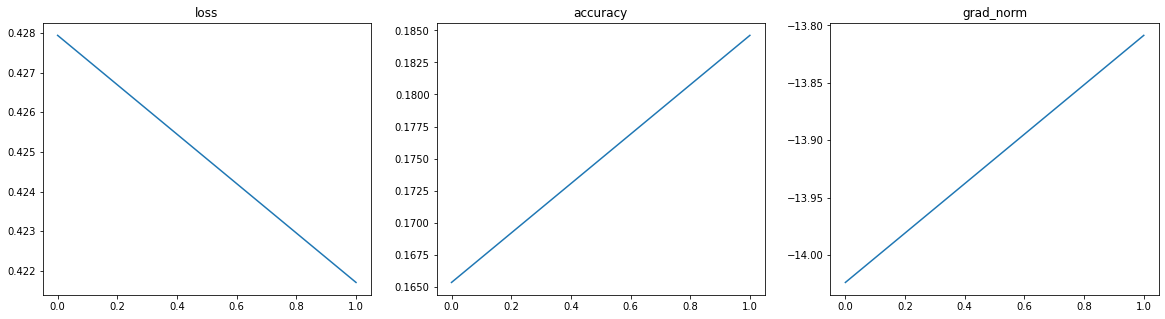

In [241]:
for epoch in range(n_epochs):
    rolling_loss = []
    rolling_metrics = {k: [] for k in metrics.keys()}
    for iter in range(n_iters):
        triples = [random_triple(bounds, max_items=5, same_number=True) for _ in range(batch_size)]

        optimizer.zero_grad()
        loss = get_loss_solve(net, triples, rolling_metrics)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        rolling_loss.append(loss.item())
        update_grad_norm(rolling_metrics, net)

    losses.append(np.mean(rolling_loss))
    for k in metrics.keys():
        metrics[k].append(np.mean(rolling_metrics[k]))

    if epoch % 1 == 0:
        print_info(epoch, metrics, losses)

In [6]:
metrics['accuracy']

[0.1339285671710968,
 0.16826923191547394,
 0.13362069427967072,
 0.14457830786705017,
 0.14453125]

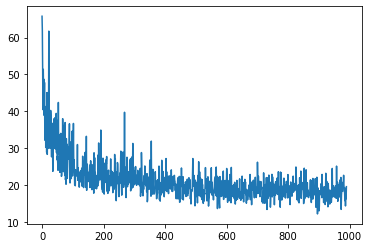

In [148]:
plt.plot(losses[10:])

Test model launcher

In [14]:
bounds = (Point(0, 0), Point(10, 10))
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

point_encoder = PointEncoder(64, device=device)
point_encoder.load_state_dict(torch.load('encoder64.pt', map_location=device))

n_epochs = 2
n_iters = 10

Point tests

In [20]:
batch_size = 64
n_epochs = 700 + 1
n_iters = 100
bounds = (Point(0, 0), Point(10, 10))
device = None #torch.device('cuda:0')

net = PointDistNet(64, 128, device)
scorer = ETAScoring()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, epochs=n_epochs, steps_per_epoch=n_iters)

losses = []

[32.07739784240723, 32.28207674026489, 30.975096015930177, 31.181254425048827, 30.857084159851073, 30.067082710266114, 29.260037326812743, 29.38694532394409, 28.345969600677492, 28.157067317962646, 27.42141839981079, 26.81521047592163, 25.36256690979004, 24.923545150756837, 23.15157648086548, 22.134758129119874, 21.79683798789978, 20.6254020690918, 19.494693441390993, 18.118298320770265, 17.21484532356262, 15.859779348373413, 14.702118043899537, 13.71334758758545, 12.441394805908203, 11.872071204185486, 10.377450623512267, 9.944466724395753, 8.851083645820617, 8.38050980091095, 7.6067618560791015, 7.344759850502014, 6.933737902641297, 6.398842446804046, 6.040468125343323, 5.9388888287544255, 5.70163596868515, 5.69664701461792, 5.60412743806839, 5.382605845928192, 5.274901347160339, 5.192345468997956]


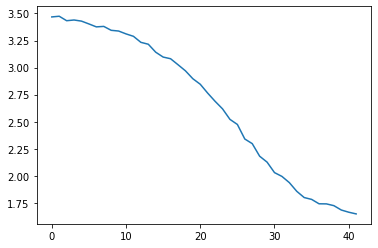

KeyboardInterrupt: 

In [21]:
for epoch in range(n_epochs):
    rolling_loss = []
    for iter in range(n_iters):
        real_distances = []
        pts1 = []
        pts2 = []
        for _ in range(batch_size):
            p1 = get_random_point(bounds)
            p2 = get_random_point(bounds)
            pts1.append(p1)
            pts2.append(p2)
            real_distances.append(distance(p1, p2))

        optimizer.zero_grad()
        mse_loss = nn.MSELoss()
        preds = net(pts1, pts2)
        loss = mse_loss(preds, torch.tensor(real_distances, device=net.device))
        loss.backward()
        optimizer.step()

        rolling_loss.append(loss.item())

    losses.append(np.mean(rolling_loss))
    if epoch % 1 == 0:
        clear_output()
        print(losses[-50:])
        plt.plot(np.log(losses))
        plt.show()

In [5]:
# torch.save(net.pe.state_dict(), 'encoder64.pt')
pe = PointEncoder(64, None)
pe.load_state_dict(torch.load('encoder64.pt', map_location=torch.device('cpu')))

<All keys matched successfully>